In [29]:
import cv2  
import math 
from matplotlib import pyplot as plt
import easyocr
import numpy as np
from ultralytics import YOLO

Función que procesa las imágenes para detectar matrículas

In [30]:
def detectar_matricula(imagen):
    
    #Carga del modelo de lengua
    reader = easyocr.Reader(['es']) 

    matricula = ""

    if imagen is not None:

        # Carga de la imagen
        img = imagen

        # img pasa a ser la mitad inferior de img
        img = img[img.shape[0]//2:, :]

        # Convertir a escala de grises
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Parámetro de gamma (ajústalo según tus necesidades)
        gamma = 3.0

        # Aplicar corrección gamma
        imagen_corregida = np.power(gray / 255.0, gamma) * 255.0

        # Asegurarse de que los valores estén en el rango [0, 255]
        imagen_corregida[imagen_corregida < 0] = 0
        imagen_corregida[imagen_corregida > 255] = 255

        # Convertir a tipo de datos entero
        imagen_corregida = imagen_corregida.astype(np.uint8)

        # Umbralizar la imagen
        _, thresh = cv2.threshold(imagen_corregida, 50, 255, cv2.THRESH_BINARY)

        # Encontrar los contornos externos
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Filtrar los contornos que tengan forma rectangular
        rect_contours = []
        for contour in contours:
            #Filtrar contornos que tengan forma rectángular y que tengan un área mayor a 1000
            if cv2.contourArea(contour) >= 300 and cv2.contourArea(contour) <= 20000:
                #Obtener el rectángulo que encierra al contorno
                rect = cv2.minAreaRect(contour)
                #Obtener los 4 vértices del rectángulo
                box = cv2.boxPoints(rect)
                #Convertir los vértices a enteros
                box = np.int0(box)

                # Calcular la relación de aspecto del rectángulo que rodea el contorno
                x, y, w, h = cv2.boundingRect(contour)
                aspect_ratio = float(w) / h

                # Filtrar por área, relación de aspecto y número de vértices
                if aspect_ratio >= 2 and img.shape[1] / w >= 3 and img.shape[1] / w <= 7:
                    posible_matricula = img[int(y):int(y+h), int(x):int(x+w)]                    
                    result = reader.readtext(posible_matricula)
                    #Si result tiene al menos un caracter
                    if result and len(result[0][1]) > 1:
                        result.sort(key=lambda x: x[2], reverse=True)  # Ordenar por confianza
                        matricula = result[0][1]
                        #Añadir el rectángulo a la lista de rectángulos
                        rect_contours.append(box)
                        
        # Dibujar los contornos encontrados
        img_contours = img.copy()
        img_contours = cv2.cvtColor(img_contours, cv2.COLOR_BGR2RGB)
        cv2.drawContours(img_contours, rect_contours, -1, (0, 255, 0), 3)

        #Comprobar si en la zona del rectángulo hay texto:
        plt.axis("off")
        plt.imshow(img_contours)

        # Ajustar diseño y mostrar gráficos
        plt.tight_layout()
        plt.show()      

        return matricula
              

    else:
        print('No se pudo cargar la imagen.')

Función que utiliza yolov8 para detectar vehículos

In [31]:
# Carga del modelo
model = YOLO('yolov8n.pt')

# Nombre de las distintas clases
classNames = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat",
              "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
              "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella",
              "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat",
              "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup",
              "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli",
              "carrot", "hot dog", "pizza", "donut", "cake", "chair", "sofa", "pottedplant", "bed",
              "diningtable", "toilet", "tvmonitor", "laptop", "mouse", "remote", "keyboard", "cell phone",
              "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors",
              "teddy bear", "hair drier", "toothbrush"
              ]

def detectar_vehiculos(imagen): 

    vehiculos = []

    if imagen is not None: 
        # Lee imagen
        img = imagen

        # Perform inference on an image
        results = model(img, stream=True)

        # Para cada detección
        for r in results:
            boxes = r.boxes

            for box in boxes:

                cls = int(box.cls[0])
                if (classNames[cls] == "car"  or classNames[cls] == "truck" or classNames[cls] == "bus"):
                    # Contenedor
                    x1, y1, x2, y2 = box.xyxy[0]
                    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2) # convert to int values
                    
                    # Confianza
                    confidence = math.ceil((box.conf[0]*100))/100

                    if confidence > 0.5:
                        # img = contenido de la imagen recogido por rectangle
                        vehiculos.append(img[y1:y2, x1:x2])

        return vehiculos

    else: 
        print('No se pudo cargar la imagen.')

Función que utiliza yolo para detectar matrículas tras el entrenamiento realizado

In [32]:
# Carga del modelo
trainedModel = YOLO('runs/detect/train/weights/best.pt')

# Nombre de las distintas clases
classNames2 = ["matricula"]

def detectar_matricula_yolo(imagen): 

    matriculas = []

    #Carga del modelo de lengua
    reader = easyocr.Reader(['es']) 

    if imagen is not None: 
        # Lee imagen
        img = imagen

        # Perform inference on an image
        results = trainedModel(img, stream=True)

        # Para cada detección
        for r in results:
            boxes = r.boxes

            for box in boxes:
                cls = int(box.cls[0])
                if (classNames2[cls] == "matricula"):
                    # Contenedor
                    x1, y1, x2, y2 = box.xyxy[0]
                    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2) # convert to int values

                    #Marcar con un rectángulo en la imagen la detección realizada
                    img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

                    matricula = img[y1:y2, x1:x2] 
                    result = reader.readtext(matricula)
                    #Si result tiene al menos un caracter
                    if result and len(result[0][1]) > 1:
                        result.sort(key=lambda x: x[2], reverse=True)  # Ordenar por confianza
                        matriculas.append(matricula)
                        print(result[0][1])

        #Mostrar un plot de img
        plt.imshow(img)
        plt.show()

    else: 
        print('No se pudo cargar la imagen.')


0: 416x640 1 car, 1 truck, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)
C:\Users\ivano\AppData\Local\Temp\ipykernel_20684\1766228778.py:48: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


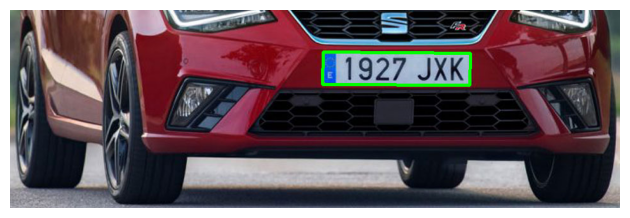


0: 384x640 1 truck, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Matrícula detectada: 1927 JXK


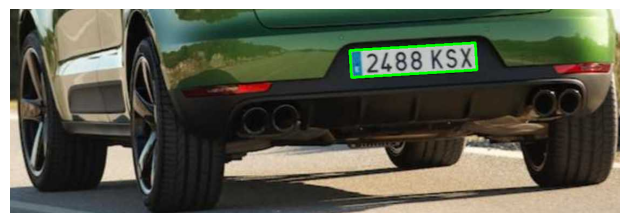


0: 448x640 1 car, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Matrícula detectada: 2488 KSX


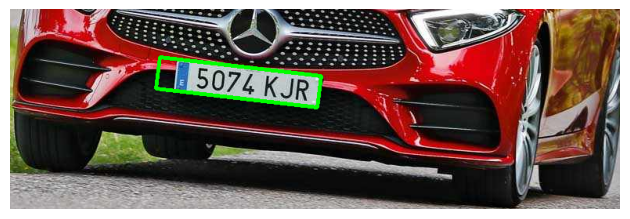


0: 416x640 1 car, 6.0ms
Speed: 2.0ms preprocess, 6.0ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)


Matrícula detectada: KJR


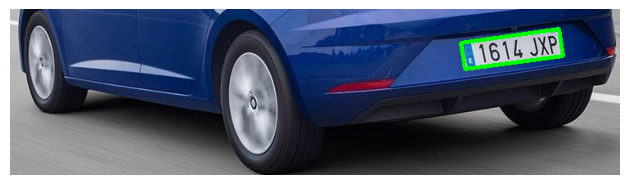


0: 448x640 1 car, 1 truck, 6.0ms
Speed: 2.0ms preprocess, 6.0ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


Matrícula detectada: 1614 JXP


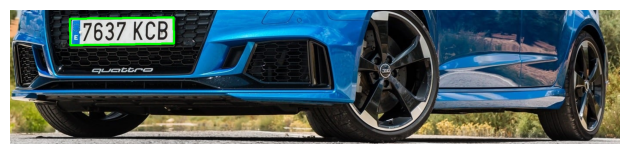


0: 384x640 1 car, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Matrícula detectada: 7637 KCB


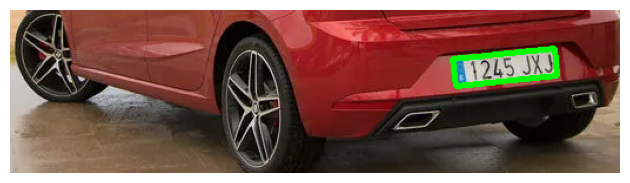


0: 384x640 1 car, 1 truck, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Matrícula detectada: JXJ


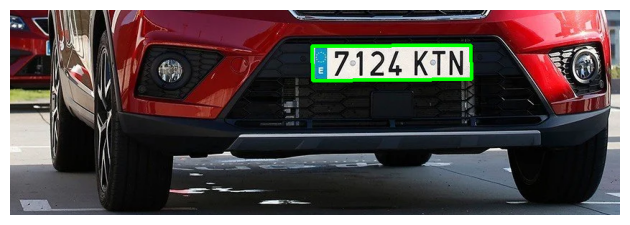


0: 384x640 1 car, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Matrícula detectada: 7124 KTN


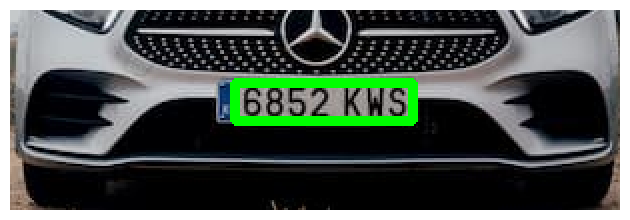


0: 384x640 1 truck, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Matrícula detectada: 6852 KWS


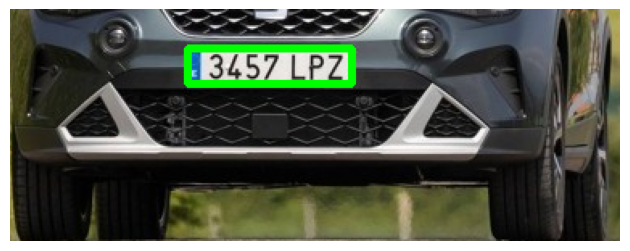


0: 384x640 1 car, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Matrícula detectada: 3457 LPZ


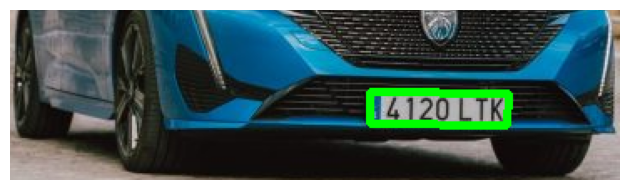


0: 384x640 1 car, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Matrícula detectada: [4120 LTK


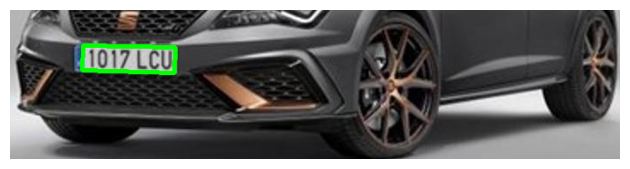


0: 640x480 1 person, 2 cars, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Matrícula detectada: 1017 LCU


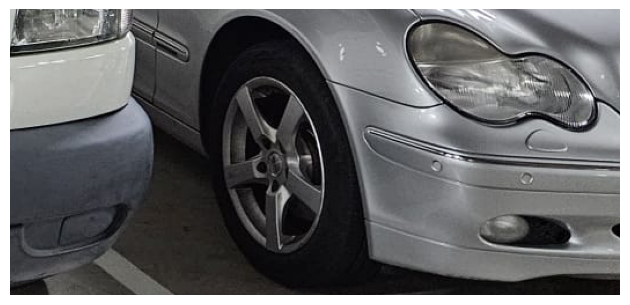

Matrícula detectada: 


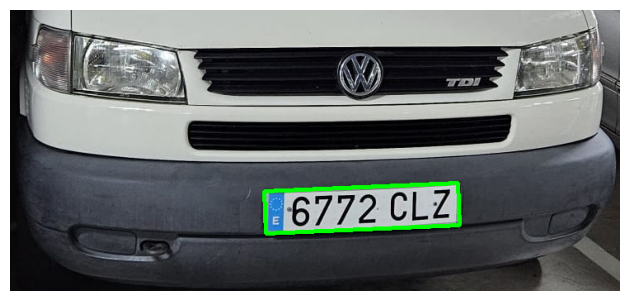

Matrícula detectada: 6772 CLZ


In [33]:
imagenes = ["im1.jpg", "im2.jpg", "im3.jpg", "im4.jpg", "im5.jpg", "im6.jpg", "coche1.jpg", "coche2.jpg", "coche3.jpg", "coche5.jpg", "im8.jpg", "im9.jpg"]



for imagen in imagenes:

    vehiculos = detectar_vehiculos(cv2.imread(imagen))

    for vehiculo in vehiculos:
        matricula = detectar_matricula(vehiculo)
        print("Matrícula detectada:", matricula)



0: 416x640 1 matricula, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


1927 JXK


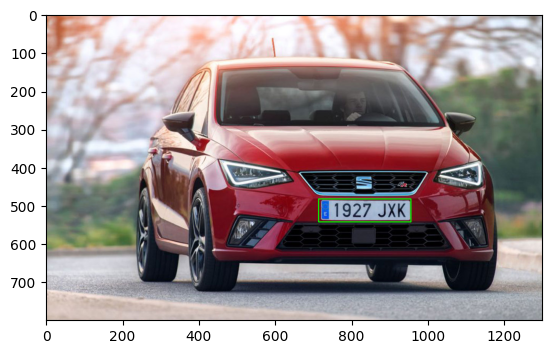


0: 384x640 1 matricula, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


2488 KSY


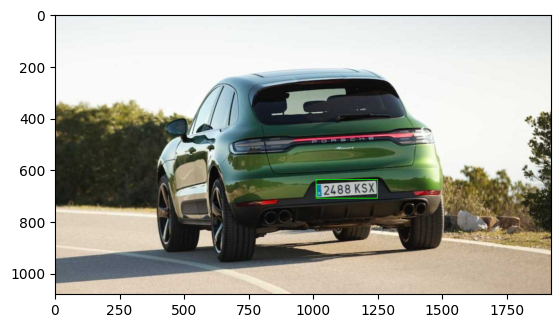


0: 448x640 1 matricula, 9.0ms
Speed: 2.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


KJR


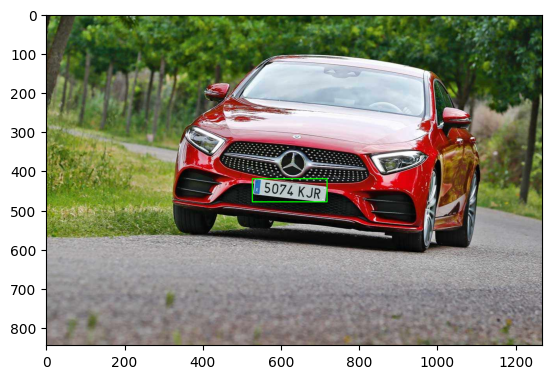


0: 416x640 1 matricula, 6.0ms
Speed: 0.8ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


1614 JXPI


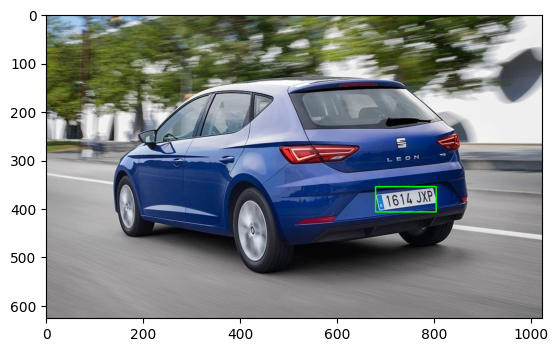


0: 448x640 1 matricula, 6.0ms
Speed: 2.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


7637 KCB


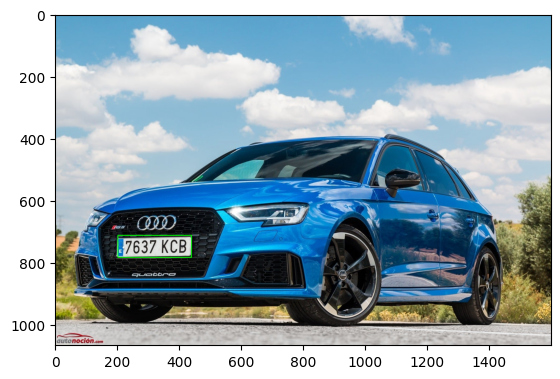


0: 384x640 1 matricula, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


JXJ


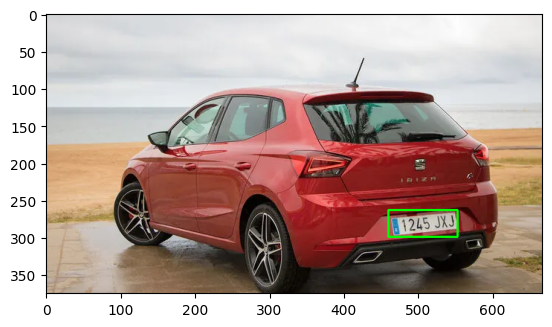


0: 384x640 1 matricula, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


7124 KTN


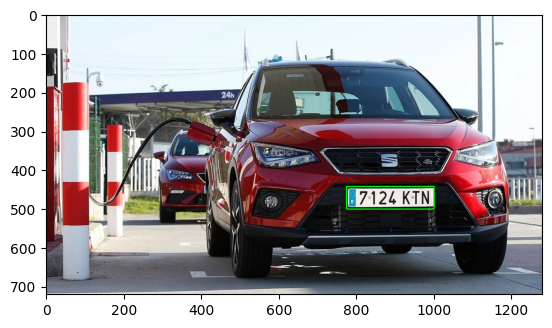


0: 384x640 1 matricula, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


[6852 KWS


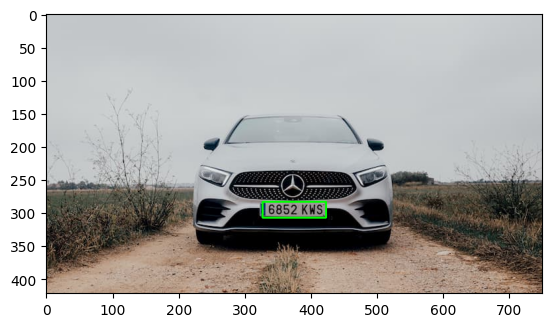


0: 384x640 1 matricula, 6.0ms
Speed: 2.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


3457 LPZ


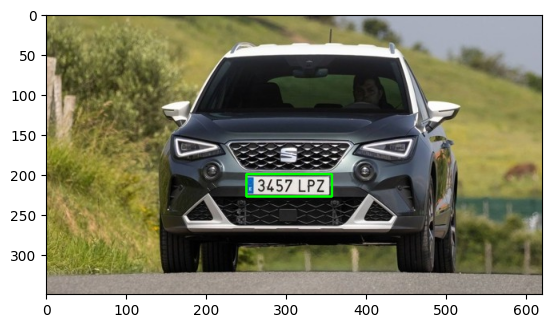


0: 384x640 1 matricula, 6.0ms
Speed: 2.0ms preprocess, 6.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


[4120 LTK


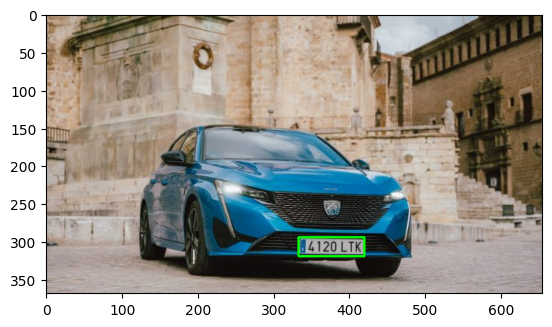


0: 384x640 1 matricula, 6.0ms
Speed: 2.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


1017 LCU


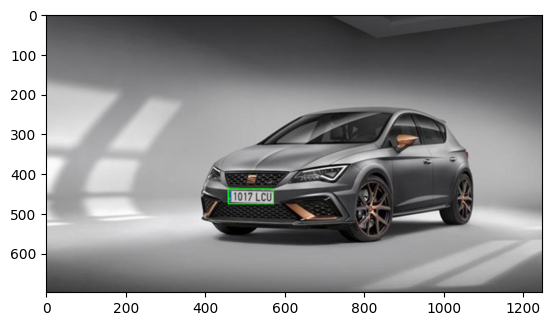


0: 640x480 1 matricula, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


6772 CLZ


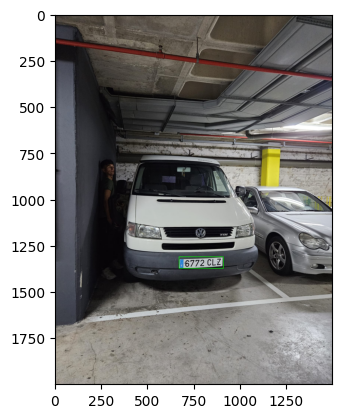

In [34]:
for imagen in imagenes:
    img = cv2.imread(imagen)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Detectamos la matrícula
    detectar_matricula_yolo(img)

Prueba de Tracking

In [35]:

# Configure the tracking parameters and run the tracker
model = YOLO('runs/detect/train/weights/best.pt')
results = model.track(source="https://www.youtube.com/watch?v=qgZySBDusxg&ab_channel=LesDebriefsDeNono", show=True)


1/1: https://www.youtube.com/watch?v=qgZySBDusxg&ab_channel=LesDebriefsDeNono... Success  (2903 frames of shape 1920x1080 at 29.97 FPS)


WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

0: 384x640 1 matricula, 10.0ms
0: 384x640 (no detections), 9.0ms
0: 384x640 (no detections), 15.6ms
0: 384x640 (no detections), 10.0ms
0: 384x640 (no detections), 14.4ms
0: 384x640 (no detections), 10.0ms
0: 384x640 (no detections), 9.0ms
0: 384x640 1 matricula, 9.1ms
0: 384x640 (no detections), 12.0ms
0: 384x640 (no de